## Early-Warning modeling of ICU capacity stress

#### Goal

Build an early-warning model that predicts whether California’s adult ICU system will enter a high-stress state within the next 1–7 days using respiratory demand signals and recent ICU dynamics. This analysis uses California state-level data from the HHS Protect dataset.

High stress is defined as total adult ICU utilization exceeding a historical high-utilization threshold (85th percentile), representing sustained operational strain rather than catastrophic overload.

#### Implementation

- Rolling 7-Day ICU Baseline (Heuristic)
Predict stress if ICU utilization has exceeded the threshold within the past 7 days.

- Model v1 — Signals Only
Logistic regression using respiratory demand signals (COVID and influenza admissions and burden) without direct ICU utilization inputs.

- Model v2 — Signals + Short-Term Dynamics
Extends v1 by adding 7-day rolling means of signals and day-to-day ICU utilization change to capture momentum effects.

#### Evaluation

- Baseline = fixed 7-day heuristic
- Models v1, v2 = expanding-window time-series validation.

Recall is emphasized to minimize missed stress events.

### Import Libraries

In [57]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

### Load data

In [58]:
# Ensure data directory exists
# Path to data directory (parent of notebooks/)
data_dir = Path("..") / "data"

# Save cleaned dataset
data = pd.read_parquet(data_dir / "hhs_cleaned.parquet")

In [59]:
data.head()

,icu_patients_confirmed_influenza,adult_icu_bed_utilization,inpatient_beds_used_covid,total_patients_hospitalized_confirmed_influenza,adult_icu_bed_covid_utilization,previous_day_admission_influenza_confirmed,previous_day_admission_adult_covid_confirmed_and_suspected,total_adult_patients_hospitalized_covid
date,,,,,,,,
2020-10-16,0.0,0.695783,3146.0,0.0,0.104452,0.0,843.0,3106.0
2020-10-17,0.0,0.683231,3076.0,0.0,0.102779,0.0,785.0,3050.0
2020-10-18,0.0,0.672031,3154.0,0.0,0.107879,0.0,770.0,3118.0
2020-10-19,4.0,0.655234,3225.0,24.0,0.111332,0.0,790.0,3092.0
2020-10-20,7.0,0.680947,3084.0,32.0,0.10653,1.0,853.0,3041.0


#### Post-Pandemic ICU Utilization Regime

The early pandemic period introduced extreme volatility, policy shocks, and structural changes in hospital operations that no longer reflect current ICU dynamics. Restricting the analysis to the post-pandemic regime allows the models to learn from more stable, operationally relevant patterns that better represent present-day surge risk behavior.

In [60]:
# Mid-2022 (post-Omicron structural shift)
cutoff = "2022-06-01"
data = data.loc[cutoff:]

#### Visualizing Feature Dynamics

Next, I examine how each feature evolves over time using a shared date index 

Plotting all retained variables on the same time axis allows for:

- Structural trends (seasonality, regime shifts) inspection

- Synchronized peaks or lead–lag behavior identification

- Anomaly detection or reporting artifacts

- Assess whether signals move before ICU stress emerges

This step ensures the temporal relationships are coherent and operationally interpretable before formal modeling begins.

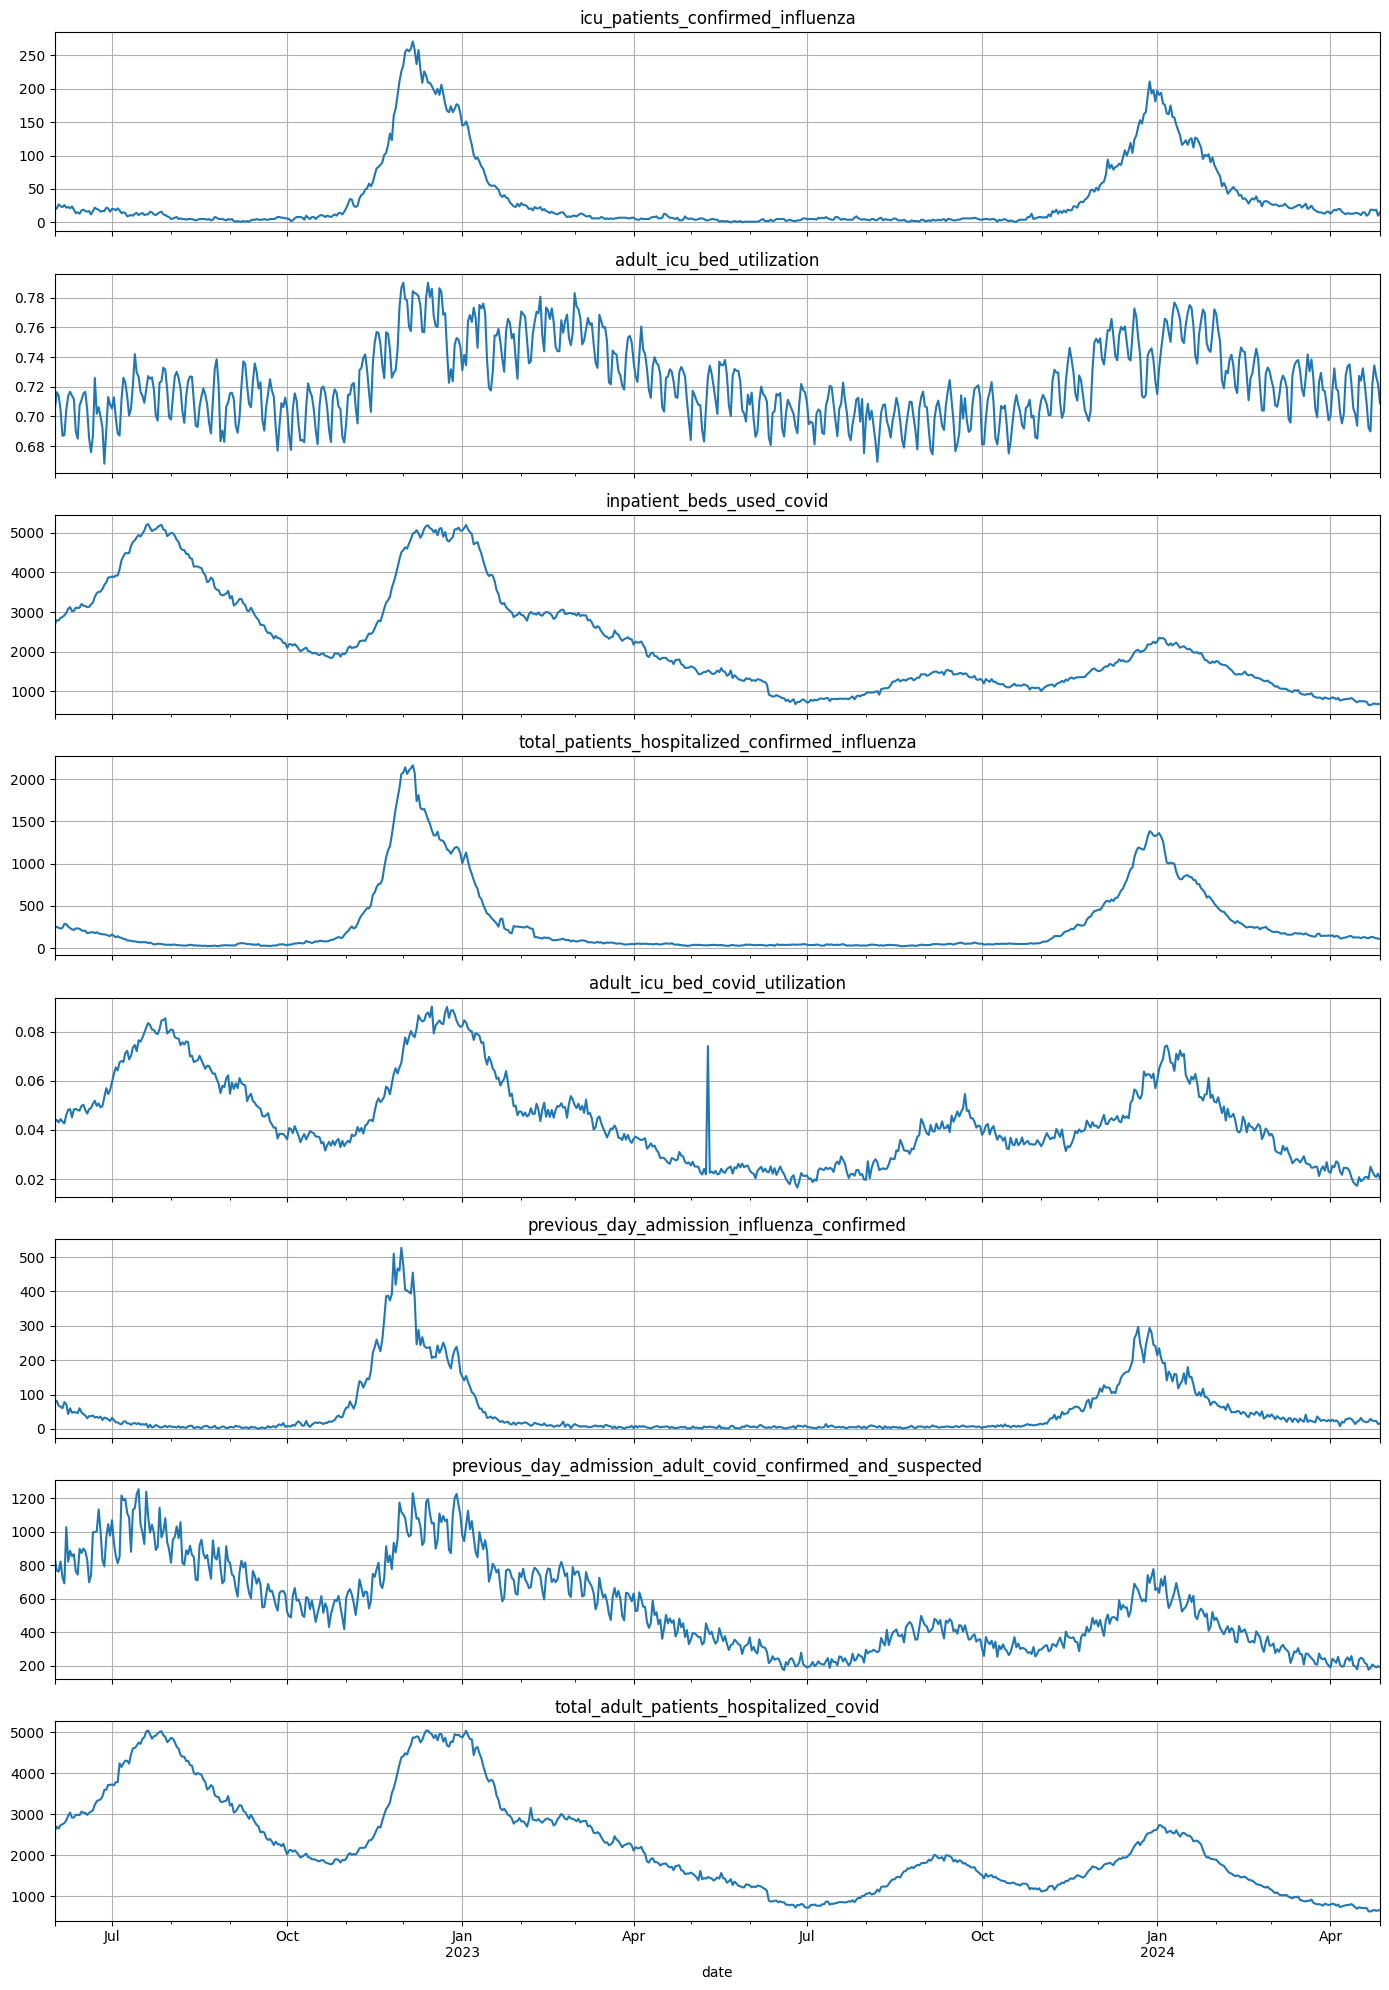

In [61]:
n = len(data.columns)
fig, axes = plt.subplots(n, 1, figsize=(14, 2.5 * n), sharex=True)

for ax, col in zip(axes, data.columns):
    data[col].plot(ax=ax)
    ax.set_title(col)
    ax.grid(True)

plt.tight_layout()
plt.show()

#### Interpretation

The plotted features show clear winter seasonality, with respiratory demand signals (influenza and COVID admissions/hospitalizations) peaking along with increases in adult ICU utilization.

ICU utilization rises more gradually, except for a ICU adult covid bed utilization sudden spike around mid-2023 probably a reporting error. I am not using this fgeature in downstream modelling, thus ignoring th eanomaly for now is okay.

Post mid-2022, volatility is lower and patterns appear more operationally stable.

### Feature Consolidation: COVID Inpatient Burden

'inpatient_beds_used_covid' and 'total_adult_patients_hospitalized_covid' move almost identically and reflect the same inpatient state/level rather than distinct demand signals. To avoid redundancy, I'll retain inpatient_beds_used_covid as a single proxy for COVID inpatient burden and rely on admission-based features for early demand signals.

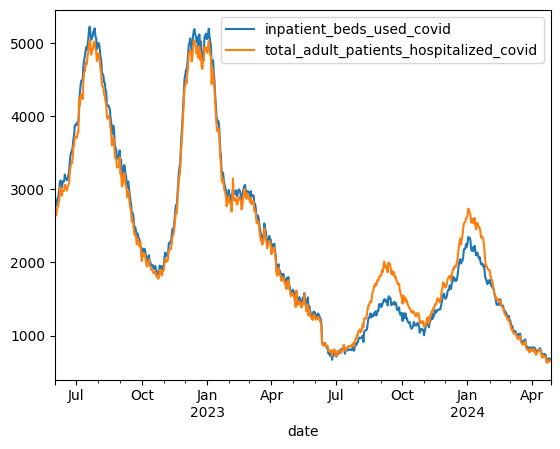

In [62]:
overlapping_cols = data[['inpatient_beds_used_covid', 'total_adult_patients_hospitalized_covid']].copy()
overlapping_cols.plot()
plt.show()

In [63]:
# Drop discovered multicollinarity
model_df = data.drop(columns=['total_adult_patients_hospitalized_covid'])

### Defining the target label

The target label answers the following early-warning question:

Will adult ICU utilization exceed a high-stress threshold at any point in the next 1–7 days?

High stress is defined using a data-driven policy threshold: the 85th percentile of the adult_icu_bed_utilization distribution. This threshold represents sustained operational strain rather than rare, catastrophic overload and provides sufficient positive examples for reliable model training.

In [64]:
# Set stress threshold
threshold = model_df['adult_icu_bed_utilization'].quantile(0.85)

# Max 'adult_icu_bed_utilization' in the next 7 days
y = model_df['adult_icu_bed_utilization']
future_7d_max = pd.Series(np.maximum.reduce([y.shift(-k) for k in range(1, 8)]), index=y.index)

# Set high stress label
model_df['icu_stress_next_7d'] = np.where(future_7d_max.notna(), (future_7d_max > threshold).astype('int'), np.nan)

In [65]:
model_df.shape

(697, 8)

In [66]:
model_df['icu_stress_next_7d'].tail(10)

date
2024-04-18    0.0
2024-04-19    0.0
2024-04-20    0.0
2024-04-21    NaN
2024-04-22    NaN
2024-04-23    NaN
2024-04-24    NaN
2024-04-25    NaN
2024-04-26    NaN
2024-04-27    NaN
Name: icu_stress_next_7d, dtype: float64

In [67]:
# Target label distribution
model_df['icu_stress_next_7d'].value_counts(normalize=True)

icu_stress_next_7d
0.0    0.728986
1.0    0.271014
Name: proportion, dtype: float64

#### Visualizing stress episodes

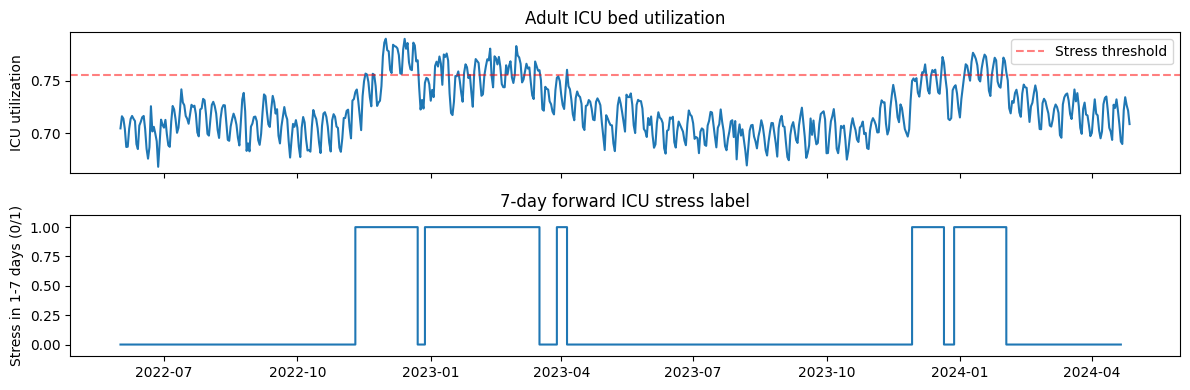

In [68]:
# Plot target
fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True)

# ICU Utilization
ax[0].plot(model_df["adult_icu_bed_utilization"])
ax[0].set_ylabel("ICU utilization")
ax[0].set_title("Adult ICU bed utilization")
ax[0].axhline(threshold, color="red", linestyle="--", alpha=0.5, label="Stress threshold")
ax[0].legend()

# Stress label
ax[1].step(model_df.index, model_df["icu_stress_next_7d"], where="post")
ax[1].set_ylabel("Stress in 1-7 days (0/1)")
ax[1].set_ylim(-0.1, 1.1)
ax[1].set_title("7-day forward ICU stress label")

plt.tight_layout()
plt.show()

#### Class Imbalance & Structural Limitation

In the post-pandemic regime (mid-2022 to 2024), defining stress at the 85th percentile yields only two stress episodes. This creates a structurally imbalanced classification problem, where positive events are rare and concentrated.

### Baseline: ICU Utilization Persistence

Assumption:

If ICU utilization has not been rising recently, it is unlikely to enter a high-stress state in the next 7 days.

In [69]:
# Rolling max of past 7 days including today; first 6 rows will have no values
# first 6 rows, will have Nan since they do not have 6 preceding days
rolling_max = model_df["adult_icu_bed_utilization"].rolling(window=7, min_periods=7).max()
baseline_cond = (rolling_max >= threshold)
pred = baseline_cond.where(rolling_max.notna()).astype('Int64')

In [70]:
pred.isna().sum()

6

In [71]:
pred.value_counts()

adult_icu_bed_utilization
0    504
1    187
Name: count, dtype: Int64

### Baseline evaluation
I evaluate the baseline, to see how a naive 7 day rolling assumption performs.

In [72]:
# Filter out rows with no rolling max values and rows without 7 days ahead
baseline_mask = pred.notna() & model_df.icu_stress_next_7d.notna()

In [73]:
baseline_true = model_df.loc[baseline_mask, "icu_stress_next_7d"].astype(int)
baseline_true

date
2022-06-07    0
2022-06-08    0
2022-06-09    0
2022-06-10    0
2022-06-11    0
             ..
2024-04-16    0
2024-04-17    0
2024-04-18    0
2024-04-19    0
2024-04-20    0
Name: icu_stress_next_7d, Length: 684, dtype: int64

In [74]:
baseline_pred = pred.loc[baseline_mask]
baseline_pred

date
2022-06-07    0
2022-06-08    0
2022-06-09    0
2022-06-10    0
2022-06-11    0
             ..
2024-04-16    0
2024-04-17    0
2024-04-18    0
2024-04-19    0
2024-04-20    0
Name: adult_icu_bed_utilization, Length: 684, dtype: Int64

In [75]:
sum(baseline_true.index == baseline_pred.index)

684

#### Baseline evaluation metrics

In [76]:
# Metrics
print("Baseline performance metrics")
print(f"Accuracy  : {accuracy_score(baseline_true, baseline_pred)}")
print(f"Precision : {precision_score(baseline_true, baseline_pred)}")
print(f"Recall    : {recall_score(baseline_true, baseline_pred)}")
print(f"F1        : {f1_score(baseline_true, baseline_pred)}")

Baseline performance metrics
Accuracy  : 0.9035087719298246
Precision : 0.8235294117647058
Recall    : 0.8235294117647058
F1        : 0.8235294117647058


### Interpretation

In this application, the most costly error is failing to anticipate a surge event. Therefore, we prioritize recall, which measures the proportion of true stress events correctly identified.

the baseline achieves:

82.4% recall
- It correctly flags about 4 out of 5 future stress periods
- It still misses roughly 1 in 5 surge events

82.4% precision
- When it raises an alert, it is correct about 82% of the time
- Around 18% of alerts are false alarms

90.4% accuracy
- High accuracy is partly influenced by class imbalance (many non-stress days)
- Accuracy is less informative here than recall

Because precision and recall are equal, the baseline misses about the same number of stress events as it falsely flags.
The baseline is reactive not predictive and it only flags risk after utilization has already been high.

### Model v1(Signals only)
Do respiratory demand signals provide early warning before utilization itself becomes elevated?

Goal:

Predict whether adult ICU utilization will enter a high-stress state within the next 1–7 days, before ICU utilization itself becomes elevated.
Instead of looking at ICU utilization (which reacts late), Model v1 looks at upstream demand signals that cause ICU stress.

In [77]:
# Expanding window walk-forward model training and evaluation
def icu_util_walk_forward_proba(X, y, train_size):

    y_actual = []
    y_proba = []
        
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression())
    ])
    
    for t in range(train_size, len(X)):
    
        X_train, y_train = X.iloc[:t], y.iloc[:t]
        X_test,  y_test  = X.iloc[t:t+1], y.iloc[t]
    
        model.fit(X_train, y_train)
    
        proba = model.predict_proba(X_test)[0, 1]
    
        y_proba.append(proba)
        y_actual.append(int(y_test))

    # eval window index (train_size -> len(X))
    eval_index = y.index[train_size:]

    return pd.Series(y_actual, index=eval_index), pd.Series(y_proba, index=eval_index)

In [78]:
model_df.columns

Index(['icu_patients_confirmed_influenza', 'adult_icu_bed_utilization',
       'inpatient_beds_used_covid',
       'total_patients_hospitalized_confirmed_influenza',
       'adult_icu_bed_covid_utilization',
       'previous_day_admission_influenza_confirmed',
       'previous_day_admission_adult_covid_confirmed_and_suspected',
       'icu_stress_next_7d'],
      dtype='object')

In [79]:
# ignore adult icu covid bed utilization
signals = ['icu_patients_confirmed_influenza', 'total_patients_hospitalized_confirmed_influenza',
           'previous_day_admission_influenza_confirmed', 'previous_day_admission_adult_covid_confirmed_and_suspected',
           'inpatient_beds_used_covid']

In [80]:
model_df.icu_stress_next_7d.shape

(697,)

In [81]:
# drop Nans from model_df 
df = model_df.dropna(subset=['icu_stress_next_7d']).copy()

In [82]:
df.icu_stress_next_7d.shape

(690,)

In [83]:
X = df[signals].copy()
y = df['icu_stress_next_7d']

In [84]:
X.shape, y.shape

((690, 5), (690,))

In [85]:
# Using log1p to uncover hidden structure in mid and low ranges in count features
X = np.log1p(X)

In [86]:
X.shape

(690, 5)

In [87]:
y_v1_true, y_v1_proba = icu_util_walk_forward_proba(X, y, 365)
y_v1_pred = (y_v1_proba >= 0.5).astype(int)

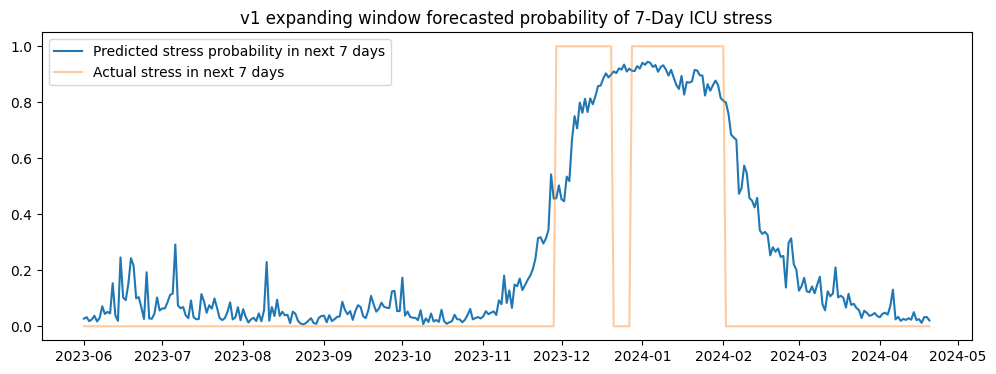

In [88]:
# Does probability rise before stress episodes?
plt.figure(figsize=(12,4))
plt.plot(y_v1_proba, label="Predicted stress probability in next 7 days")
plt.plot(y_v1_true, label="Actual stress in next 7 days", alpha=0.4)
plt.legend()
plt.title("v1 expanding window forecasted probability of 7-Day ICU stress")
plt.show()

In [89]:
print("Model v1 evaluation metrics")
print("Accuracy : ", accuracy_score(y_v1_true, y_v1_pred))
print("Precision: ", precision_score(y_v1_true, y_v1_pred))
print("Recall   : ", recall_score(y_v1_true, y_v1_pred))
print("F1       : ", f1_score(y_v1_true, y_v1_pred))

Model v1 evaluation metrics
Accuracy :  0.9446153846153846
Precision:  0.7857142857142857
Recall   :  0.9482758620689655
F1       :  0.859375


### Interpretation

Model v1 successfully reduces missed surge events compared to the baseline.

Unlike the baseline, which reacts after ICU utilization has already been elevated, model v1 uses upstream respiratory signals (admissions, influenza burden, COVID inpatient counts) to anticipate stress before utilization itself crosses the threshold.

### Model v2 (Signals + Momentum + Smoothed Signals)

Question:
Does incorporating ICU momentum and smoothed respiratory demand improve early stress detection?

Goal:
Predict whether adult ICU utilization will enter a high-stress state within the next 1–7 days by incorporating:

- Upstream respiratory demand signals
- Recent ICU utilization momentum (day-over-day change)
- Smoothed respiratory demand (7-day rolling averages)

Unlike Model v1 (signals only), Model v2 uses:

- Momentum which captures whether the system is already moving toward the threshold.
- Smoothed signals indicating whether respiratory inflow is persistently elevated rather than noisy

In other words:
Model v2 models not just incoming pressure, but how that pressure is compounding over time.

### Momentum

In [90]:
df['adult_icu_bed_utilization_daily_change'] = df.adult_icu_bed_utilization.diff()

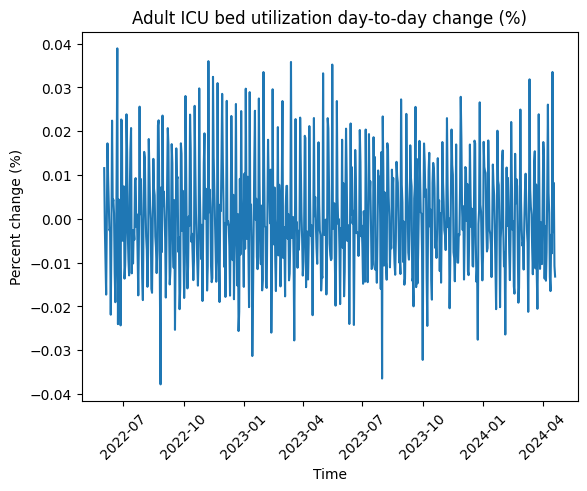

In [91]:
plt.plot(df['adult_icu_bed_utilization_daily_change'])
plt.title('Adult ICU bed utilization day-to-day change (%)')
plt.ylabel('Percent change (%)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.show()

### Smoothed signals

In [92]:
# casual rolling windows, last '7 days mean' features
smoothed_signals = []

for col in signals:
    smoothed_signals.append(f"{col}_rol_7")
    df[f"{col}_rol_7"] = df[col].rolling(window=7, min_periods=7).mean()

In [93]:
df.isna().sum().sort_values(ascending=False)

icu_patients_confirmed_influenza_rol_7                              6
total_patients_hospitalized_confirmed_influenza_rol_7               6
previous_day_admission_influenza_confirmed_rol_7                    6
previous_day_admission_adult_covid_confirmed_and_suspected_rol_7    6
inpatient_beds_used_covid_rol_7                                     6
adult_icu_bed_utilization_daily_change                              1
icu_patients_confirmed_influenza                                    0
adult_icu_bed_utilization                                           0
inpatient_beds_used_covid                                           0
total_patients_hospitalized_confirmed_influenza                     0
adult_icu_bed_covid_utilization                                     0
previous_day_admission_influenza_confirmed                          0
previous_day_admission_adult_covid_confirmed_and_suspected          0
icu_stress_next_7d                                                  0
dtype: int64

In [94]:
smoothed_signals_and_momentum = signals + smoothed_signals + ['adult_icu_bed_utilization_daily_change']
smoothed_signals_and_momentum

['icu_patients_confirmed_influenza',
 'total_patients_hospitalized_confirmed_influenza',
 'previous_day_admission_influenza_confirmed',
 'previous_day_admission_adult_covid_confirmed_and_suspected',
 'inpatient_beds_used_covid',
 'icu_patients_confirmed_influenza_rol_7',
 'total_patients_hospitalized_confirmed_influenza_rol_7',
 'previous_day_admission_influenza_confirmed_rol_7',
 'previous_day_admission_adult_covid_confirmed_and_suspected_rol_7',
 'inpatient_beds_used_covid_rol_7',
 'adult_icu_bed_utilization_daily_change']

In [95]:
df.isna().sum()

icu_patients_confirmed_influenza                                    0
adult_icu_bed_utilization                                           0
inpatient_beds_used_covid                                           0
total_patients_hospitalized_confirmed_influenza                     0
adult_icu_bed_covid_utilization                                     0
previous_day_admission_influenza_confirmed                          0
previous_day_admission_adult_covid_confirmed_and_suspected          0
icu_stress_next_7d                                                  0
adult_icu_bed_utilization_daily_change                              1
icu_patients_confirmed_influenza_rol_7                              6
total_patients_hospitalized_confirmed_influenza_rol_7               6
previous_day_admission_influenza_confirmed_rol_7                    6
previous_day_admission_adult_covid_confirmed_and_suspected_rol_7    6
inpatient_beds_used_covid_rol_7                                     6
dtype: int64

In [96]:
df.shape

(690, 14)

In [97]:
df = df.dropna()

In [98]:
df.shape

(684, 14)

In [99]:
X_v2 = df[smoothed_signals_and_momentum]
y_v2 = df['icu_stress_next_7d']

In [100]:
X_v2.head()

,icu_patients_confirmed_influenza,total_patients_hospitalized_confirmed_influenza,previous_day_admission_influenza_confirmed,previous_day_admission_adult_covid_confirmed_and_suspected,inpatient_beds_used_covid,icu_patients_confirmed_influenza_rol_7,total_patients_hospitalized_confirmed_influenza_rol_7,previous_day_admission_influenza_confirmed_rol_7,previous_day_admission_adult_covid_confirmed_and_suspected_rol_7,inpatient_beds_used_covid_rol_7,adult_icu_bed_utilization_daily_change
date,,,,,,,,,,,
2022-06-07,22.0,283.0,72.0,1027.0,2980.0,23.142857,253.714286,71.571429,805.571429,2841.857143,0.017217
2022-06-08,23.0,254.0,43.0,821.0,3085.0,23.714286,254.571429,66.714286,802.857143,2898.142857,0.009228
2022-06-09,21.0,236.0,60.0,886.0,3123.0,23.714286,252.428571,63.571429,819.714286,2945.285714,0.002881
2022-06-10,24.0,223.0,47.0,854.0,3023.0,23.285714,250.000000,60.714286,832.857143,2978.857143,-0.002671
2022-06-11,19.0,215.0,49.0,866.0,3029.0,22.571429,247.857143,58.428571,839.142857,3004.142857,-0.002232


In [101]:
X_v2 = np.log1p(X_v2)

In [102]:
y_v2_true, y_v2_proba = icu_util_walk_forward_proba(X_v2, y_v2, 365)
y_v2_pred = (y_v2_proba >= 0.5).astype(int)

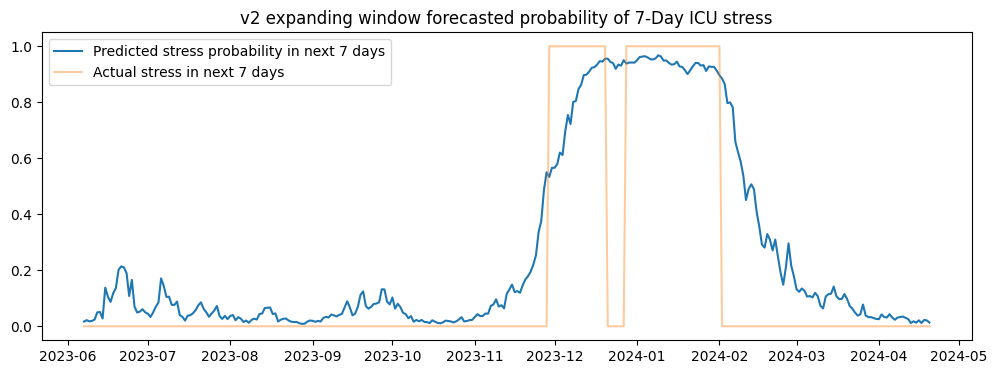

In [103]:
# Does probability rise before stress episodes?
plt.figure(figsize=(12,4))
plt.plot(y_v2_proba, label="Predicted stress probability in next 7 days")
plt.plot(y_v2_true, label="Actual stress in next 7 days", alpha=0.4)
plt.legend()
plt.title("v2 expanding window forecasted probability of 7-Day ICU stress")
plt.show()

### Plots interpretation
In both model plots, predicted stress probability rises before the actual stress window begins. This confirms that the models are learning upstream pressure rather than reacting to threshold crossing.

Model v2’s probability curve rises in a more gradual and structured way prior to the stress window compoared to v1, which suggests rolling signals reduce noise and momentum features help capture acceleration.

Given the small number of stress episodes, visualization is important evidence that the model is learning meaningful temporal structure rather than random separation.

In [104]:
print("Model v2 evaluation metrics")
print("Accuracy : ", accuracy_score(y_v2_true, y_v2_pred))
print("Precision: ", precision_score(y_v2_true, y_v2_pred))
print("Recall   : ", recall_score(y_v2_true, y_v2_pred))
print("F1       : ", f1_score(y_v2_true, y_v2_pred))

Model v2 evaluation metrics
Accuracy :  0.9435736677115988
Precision:  0.7631578947368421
Recall   :  1.0
F1       :  0.8656716417910447


### Interpretation

There were no false negatives. This means every future high stress episode was flagged in advance.
The model never failed to raise an alert before a stress window.
For an early-warning system, this is strong performance especially since missed surges are the most costly error.

The dataset is imbalanced (many non-stress days), therefore accuracy is less informative than recall.
With only a few stress episodes, it is easier to achieve perfect recall but this also makes the results fragile.

### baseline vs model v1 vs model v2

### i. Performance comparison

In [105]:
baseline_true.shape, baseline_pred.shape, y_v1_true.shape, y_v1_pred.shape, y_v2_true.shape, y_v2_pred.shape

((684,), (684,), (325,), (325,), (319,), (319,))

In [106]:
# apples to apples comparison, on predictions
index = y_v2_true.index

# Baseline prediction already computed
baseline_true = baseline_true.loc[index]
baseline_pred = baseline_pred.loc[index]

y_v1_true = y_v1_true.loc[index]
y_v1_pred = y_v1_pred.loc[index]

In [107]:
baseline_true.shape, baseline_pred.shape, y_v1_true.shape, y_v1_pred.shape, y_v2_true.shape, y_v2_pred.shape

((319,), (319,), (319,), (319,), (319,), (319,))

In [108]:
# ensure index is same before comparison
print(all(baseline_true.index == y_v1_true.index))
print(all(y_v1_true.index == y_v2_true.index))
print(all(y_v2_true.index == y_v2_pred.index))

True
True
True


In [109]:
print("Baseline evaluation metrics")
print("Accuracy : ", accuracy_score(baseline_true, baseline_pred))
print("Precision: ", precision_score(baseline_true, baseline_pred))
print("Recall   : ", recall_score(baseline_true, baseline_pred))
print("F1       : ", f1_score(baseline_true, baseline_pred))
print("ROC-AUC  : ", roc_auc_score(baseline_true, baseline_pred))
print('\n--------')
print("Model v1 evaluation metrics")
print("Accuracy : ", accuracy_score(y_v1_true, y_v1_pred))
print("Precision: ", precision_score(y_v1_true, y_v1_pred))
print("Recall   : ", recall_score(y_v1_true, y_v1_pred))
print("F1       : ", f1_score(y_v1_true, y_v1_pred))
print("ROC-AUC  : ", roc_auc_score(y_v1_true, y_v1_pred))
print('\n--------')
print("Model v2 evaluation metrics")
print("Accuracy : ", accuracy_score(y_v2_true, y_v2_pred))
print("Precision: ", precision_score(y_v2_true, y_v2_pred))
print("Recall   : ", recall_score(y_v2_true, y_v2_pred))
print("F1       : ", f1_score(y_v2_true, y_v2_pred))
print("ROC-AUC  : ", roc_auc_score(y_v2_true, y_v2_pred))

Baseline evaluation metrics
Accuracy :  0.9122257053291536
Precision:  0.7586206896551724
Recall   :  0.7586206896551724
F1       :  0.7586206896551724
ROC-AUC  :  0.8524904214559387

--------
Model v1 evaluation metrics
Accuracy :  0.9435736677115988
Precision:  0.7857142857142857
Recall   :  0.9482758620689655
F1       :  0.859375
ROC-AUC  :  0.9454022988505747

--------
Model v2 evaluation metrics
Accuracy :  0.9435736677115988
Precision:  0.7631578947368421
Recall   :  1.0
F1       :  0.8656716417910447
ROC-AUC  :  0.9655172413793103


In [111]:
print(classification_report(y_v2_true, y_v2_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       261
           1       0.76      1.00      0.87        58

    accuracy                           0.94       319
   macro avg       0.88      0.97      0.91       319
weighted avg       0.96      0.94      0.95       319



#### Question: Are the models early-warning?

In [97]:
# Are the models early-warning?
def compute_lead_times(y_true, y_pred, stress_starts, window=7):
    lead_times = []

    for start_date in stress_starts:
        start_idx = y_true.index.get_loc(start_date)

        # Look back up to `window` days
        lookback_start = max(0, start_idx - window)
        lookback_slice = y_pred.iloc[lookback_start:start_idx]

        # Find first predicted 1 in lookback window
        if lookback_slice.any():
            first_alert_idx = lookback_slice[lookback_slice == 1].index[0]
            lead = (start_date - first_alert_idx).days
            lead_times.append(lead)
        else:
            # No early warning
            lead_times.append(0)

    return lead_times

In [98]:
# Is the model a better early-winning predictor than the baseline
# Identify start of each stress episode
stress_start = (baseline_true == 1) & (baseline_true.shift(1) == 0)

# When did stress episode start?
stress_start_dates = baseline_true.index[stress_start]

In [99]:
# lead times
baseline_leads = compute_lead_times(baseline_true, baseline_pred, stress_start_dates)
v1_leads = compute_lead_times(y_v1_true, y_v1_pred, stress_start_dates)
v2_leads = compute_lead_times(y_v2_true, y_v2_pred, stress_start_dates)
baseline_leads, v1_leads, v2_leads

([0, 7], [2, 7], [1, 7])

In [100]:
print(f'Baseline average days in advance: {np.mean(baseline_leads)}')
print(f'Model v1 average days in advance: {np.mean(v1_leads)}')
print(f'Model v2 average days in advance: {np.mean(v2_leads)}')

Baseline average days in advance: 3.5
Model v1 average days in advance: 4.5
Model v2 average days in advance: 4.0


### Conclusion

From the early-warning results above: 

- The baseline sometimes reacts on the same day stress begins (0-day lead)
- Model v1 consistently provides earlier signal on the harder episode (+2 days vs 0)
- Model v2 also anticipates stress earlier than baseline.

Models v1 and v2 qualify as early-warning models because predicted stress probabilities rise several days before the system crosses the stress threshold, indicating predictive rather than reactive behavior.

Baseline:

- Misses about 1 in 4 stress periods
- Flags risk only after utilization has already been high in the recent past, limiting its anticipatory value
  
Model v1 (Signals Only):

- Major recall improvement about 95%
- Provides the longest average early warning (4.5 days on average)
- Demonstrates upstream respiratory signals contain predictive information
- Produced best balance of recall and precision

Model v2 (Signals + Momentum + Smoothed signals):

- Achieved perfect recall within the evaluation window (no missed stress episodes in this sample)
- Slight drop in precision (more false alarms)
- Slightly shorter lead than model v1

Tradeoffs:

1. Recall vs Precision
- v2 maximizes recall (no missed surges)
- v1 provides slightly better precision
- Baseline underperforms both.

2. Lead Time
- v1 offers the strongest early signal
- v2 remains strong but slightly less early
- Baseline lags

### Caveat

The evaluation window(mid 2023 - 2024) contains only two stress episodes, creating a highly imbalanced and statistically fragile setting. As a result, performance estimates—particularly perfect recall—may not generalize. Results should be interpreted as directional rather than definitive.

Model robustness must be tested under different thresholds or longer horizons.

### Next steps

##### Model interpretability (SHAP)
SHAP analysis to Model v2 to quantify which signals most strongly drive predicted surge risk. This validates that the model is responding to ICU utilization drivers (e.g., respiratory admissions, ICU momentum) rather than noise, and strengthens interpretability for operational stakeholders.

##### Decision threshold calibration
The ICU utilization percentile threshold defines what constitutes stress. Separately, the probability cutoff determines when to trigger an alert. The next step is to calibrate the probability threshold to achieve an operationally aligned target recall level (e.g., ≥90%) while monitoring alert frequency.